# PDAC Calibration - 1y probability changes

Author: Sophie Wagner, sw3767@cumc.columbia.edu

## Packages, notebook preferences, etc.

In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime
import random 

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set up matrix

In [2]:
def row_normalize(matrix):
    
    for age_layer in range(matrix.shape[0]):
        layer = matrix[age_layer, :7, :]
        non_diag_sum = np.sum(layer, axis=1) - np.diagonal(layer)

        # Scale rows if non-diagonal sum exceeds 1
        scaling_factors = np.clip(1 / non_diag_sum, None, 1)
        layer *= scaling_factors[:, np.newaxis]  # Scale entire row

        # Adjust diagonal elements to ensure each row sums to 1
        np.fill_diagonal(layer, np.maximum(0, 1 - np.sum(layer, axis=1) + np.diagonal(layer)))

        # Update the matrix for the current age layer
        matrix[age_layer, :7, :] = layer

    return matrix.clip(0.0, 1.0)

def create_matrix():
    
    matrix = np.zeros((len(c.age_layers), len(c.health_states_itos), len(c.health_states_itos)))
    age_50_idx = 30
    matrix[:, 0, 1] = (1-(1-0.0011)**(1/25)) * 4 # average risk after 50 ~ 0.0011, transformed to annual prob
    # matrix[:age_50_idx, 0, 1] = np.linspace(0.000002,matrix[-1,0,1],age_50_idx)
    matrix[:, 1, 2] = c.model_inputs_dict['p_Local_to_Regional_PC']
    matrix[:, 2, 3] = c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 1, 4] = c.model_inputs_dict['p_symptom_local'] 
    matrix[:, 2, 5] = c.model_inputs_dict['p_symptom_regional']
    matrix[:, 3, 6] = c.model_inputs_dict['p_symptom_distant']
    
    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    
    matrix[:, 0, 1] = np.maximum(matrix[:,0,1], 0.000001)
    # matrix[:, 0, 1] = np.maximum.accumulate(matrix[:, 0, 1])
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2]).clip(0.05, 1.0)
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3]).clip(0.1, 1.0)
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5]).clip(0.1, 1.0)
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6]).clip(0.2, 1.0)
    
    # Maintain logical consistency
    matrix[:, 1, 4] = np.minimum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 2, 5] = np.minimum(matrix[:, 2, 5], matrix[:, 3, 6])
    
    return matrix


def add_acm(matrix):
    
    matrix[:, :7, 8] = c.acm_rates[:, np.newaxis]
    matrix[:, 8, 8] = 1
    
    return matrix


def add_csd(matrix):  # Constant death rate in calibration
    
    matrix[:, 4, 7] = c.model_inputs_dict['p_local_death']
    matrix[:, 5, 7] = c.model_inputs_dict['p_regional_death']
    matrix[:, 6, 7] = c.model_inputs_dict['p_distant_death']
    matrix[:, 7, 7] = 1
    
    return matrix

## Markov model

In [3]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (13, 9, 9)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if current_age in c.ages_1y:
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj, pop_log

## Calibration

In [4]:
def step(matrix, step_size, num_adj=3):
    """
    Updates a parameter matrix, using reduced 5-y interval matrix (to reduce number of
    parameters to adjust, faster convergence, smoother parameter change). Randomly 
    selected transitions and age groups are adjusted by a scaled step size, then smoothed
    and interpolated to get yearly values.

    Args:
        matrix (numpy.ndarray): Full parameter matrix for all ages and transitions.
        step_size (float): Scale of parameter adjustments.
        num_adj (int): Number of parameters to modify.

    Returns:
        numpy.ndarray: Updated matrix with smoothed yearly transition probabilities.
    """
    points = list(c.transitions_itos.keys()) 
    step_tp = random.choices(points, k=num_adj)
    step_age = random.choices(c.age_layers_adj, k=num_adj)
    small_matrix = matrix[2::5, :, :]
    assert small_matrix.shape[0] == 13
    
    for i in range(num_adj):
        (from_state, to_state), age = step_tp[i], step_age[i]
        old_param = small_matrix[age, from_state, to_state] 
        step_param = (old_param * step_size).clip(0.00001, 0.1)
        small_matrix[age, from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)

    new_matrix = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], small_matrix, axis=0, smooth=0.01)(c.ages_1y).clip(0.0,1.0)
        
    # elif c.risk=="double":
    #     new_matrix = np.copy(matrix)
    #     for i in range(num_adj):
    #         (from_state, to_state) = step_tp[i]
    #         old_param = new_matrix[0, from_state, to_state] 
    #         step_param = (old_param * step_size).clip(0.00005, 0.1)
    #         new_param = old_param + np.random.uniform(low=-step_param, high=step_param)
    #         new_matrix[:, from_state, to_state] = new_param
            
    assert new_matrix.shape[0]==65
    new_matrix = add_acm(new_matrix)  # ACM
    new_matrix = add_csd(new_matrix)  # CSD
    new_matrix = constrain_matrix(new_matrix)  # constrain
    new_matrix = row_normalize(new_matrix)  # normalize

    return new_matrix

In [5]:
def progress_report(iteration, best_eval, best_log, ticker, best_t):
    """
    Prints progress report during simulated annealing.
    """
    log_adj, _, inc_log, _ = best_log
    total_dxd = np.sum(inc_log[4:7, :]) / c.N
    print(f"{iteration}: Best Eval: {best_eval:.5f}, PDAC: {total_dxd:.5f}, Tick: {ticker}")
    
    if iteration % 50000 == 0:
        transition_probs = p.extract_transition_probs(best_t, metric="avg")
        print(f"Detailed Progress Report, Iteration = {iteration}")
        print(transition_probs)
        p.plot_vs_seer(log_adj, c.seer_inc)

In [6]:
def simulated_annealing(n_iterations, step_size, start_tmat, n_adj=5, starting_temp=1, verbose=False, print_interval=1000):
    """
    Performs simulated annealing to optimize a transition matrix.

    Args:
        n_iterations (int): Number of iterations for optimization.
        step_size (float): Step size for parameter adjustments.
        start_tmat (numpy.ndarray): Initial transition matrix.
        n_adj (int): Number of parameters to adjust per step.
        starting_temp (float): Initial temperature for annealing.
        verbose (bool): Whether to print progress reports.
        print_interval (int): Interval for progress reporting.

    Returns:
        numpy.ndarray: Optimized transition matrix.
    """
    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = gof.objective(best_log)
    curr_t, curr_eval = best_t, best_eval
    scheduler, ticker, iter_count = 0, 0, 0 

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        for i in range(n_iterations):
            # Generate candidate solution
            candidate_t = step(np.copy(curr_t), step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = gof.objective(candidate_log)

            # Update best solution
            if candidate_eval < best_eval:
                ticker, scheduler = 0, 0
                best_t, best_eval = np.copy(candidate_t), candidate_eval
                best_log = run_markov(best_t)

                # Dynamically adjust parameters on improvement
                step_size = max(0.9 * step_size, 0.075)  # Decay step size slightly
                starting_temp = max(0.95 * starting_temp, 1)  # Gradual cooling
                n_adj = max(2, n_adj - 1)  # Reduce number of adjustments for precision
                
                # print(f"UPDATE ACCOMPLISHED at iteration {i}!")
                # print(f"Best Eval: {best_eval} | Step Size: {step_size:.4f} | Temp: {starting_temp:.2f} | n_adj: {n_adj}")
                
            else:
                ticker += 1
                iter_count+=1
                scheduler+=1

            # Calculate temperature and Metropolis acceptance criterion
            t = starting_temp / (1 + 0.01 * np.sqrt(iter_count + 1))  # Adaptive cooling
            diff = candidate_eval - curr_eval
            metropolis = np.exp(-diff / t)

            if diff < 0 or np.random.random() < metropolis:
                curr_t, curr_eval = np.copy(candidate_t), candidate_eval

            # Print progress report
            if verbose and i > 0 and i % print_interval == 0:
                progress_report(i, best_eval, best_log, ticker, best_t)

            # Adjust or reset exploration parameters periodically
            if scheduler > 50000:  # Long stagnation
                step_size = np.random.uniform(0.1, 0.3)  # Randomize step size
                starting_temp = np.random.uniform(10, 50)  # Reset temperature
                n_adj = np.random.choice(range(1, 12))  # Random adjustments
                scheduler, iter_count = 0, 0, 0 # Reset 
            elif scheduler > 15000:  # Medium stagnation
                step_size = min(step_size + 0.05, 0.3)  # Increase step size for exploration
                starting_temp = min(starting_temp + 2, 50)  # Boost temperature for exploration
                n_adj = np.random.choice(range(3, 10))  # Randomize number of parameters to adjust
                scheduler, iter_count = 0, 0  # Reset stagnation counter

                
            pbar.update(1)

    print("Best evaluation:", best_eval)
    return best_t

## Run simulated annealing

In [7]:
def run_sa(tmat=None, save_all=False, n_iterations=50000, step_size=0.2, n_adj=5, starting_temp=1, print_interval=5000):
    
    start_tmat = None
    start_tmat = tmat if tmat is not None else create_matrix()   
    initial_score = gof.objective(run_markov(start_tmat))
    print(f"Initial score: {round(initial_score, 5)}")
    print("Starting calibration...")
    
    result = simulated_annealing(n_iterations=n_iterations, step_size=step_size, start_tmat=start_tmat, n_adj=n_adj, starting_temp=starting_temp, verbose=True, print_interval=print_interval)
    
    # Gather results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    log_adj, log_prev, log_inc, pop_log = curr_log
    final_score = gof.objective(run_markov(curr_tmat))
    
    save = True if final_score < initial_score else save_all
    
    print("Done.")
    
    # Saving
    if save:
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        pd.DataFrame(pop_log.T).to_csv(f"{log_path}/{timestamp}_pop_log.csv")
        p.plot_vs_seer(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)

    return curr_tmat

In [57]:
result = np.load("../out/double/tmats/20241226_1726_tmat.npy")
lr=0.25
for epoch in range(5):
    print(f"EPOCH {(epoch+1)}/5 ----------------------------------------------------------")
    result = run_sa(tmat=result, save_all=True, n_iterations=250000, step_size=lr, n_adj=3, starting_temp=10)
    lr -= 0.025

EPOCH 1/5 ----------------------------------------------------------
Initial score: 1495.60311
Starting calibration...


Simulated annealing progress:   2%|▏         | 5036/250000 [00:19<15:21, 265.89iteration/s]

5000: Best Eval: 1107.69429, PDAC: 0.01395, Tick: 16


Simulated annealing progress:   4%|▍         | 10039/250000 [00:39<15:41, 254.92iteration/s]

10000: Best Eval: 1052.09691, PDAC: 0.01374, Tick: 851


Simulated annealing progress:   6%|▌         | 15038/250000 [00:58<14:53, 263.11iteration/s]

15000: Best Eval: 1052.09691, PDAC: 0.01374, Tick: 5851


Simulated annealing progress:   8%|▊         | 20029/250000 [01:19<17:37, 217.51iteration/s]

20000: Best Eval: 1041.32563, PDAC: 0.01379, Tick: 1997


Simulated annealing progress:  10%|█         | 25057/250000 [01:41<14:30, 258.53iteration/s]

25000: Best Eval: 1021.58418, PDAC: 0.01376, Tick: 321


Simulated annealing progress:  12%|█▏        | 30056/250000 [02:00<14:07, 259.64iteration/s]

30000: Best Eval: 1021.58418, PDAC: 0.01376, Tick: 5321


Simulated annealing progress:  14%|█▍        | 35032/250000 [02:20<14:21, 249.65iteration/s]

35000: Best Eval: 1020.52194, PDAC: 0.01381, Tick: 2826


Simulated annealing progress:  16%|█▌        | 40037/250000 [02:39<13:51, 252.49iteration/s]

40000: Best Eval: 992.18680, PDAC: 0.01364, Tick: 4383


Simulated annealing progress:  18%|█▊        | 45036/250000 [02:59<13:15, 257.63iteration/s]

45000: Best Eval: 992.18680, PDAC: 0.01364, Tick: 9383


Simulated annealing progress:  20%|██        | 50050/250000 [03:18<13:14, 251.82iteration/s]

50000: Best Eval: 992.18680, PDAC: 0.01364, Tick: 14383
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00740  0.00818  0.00688  0.00822  0.00783
1  u_PDAC_loc  u_PDAC_reg  0.00799  0.00848  0.00792  0.00848  0.00824
2  u_PDAC_reg  u_PDAC_dis  0.00969  0.01022  0.00968  0.01024  0.00994
3  u_PDAC_loc  d_PDAC_loc  0.00014  0.00017  0.00013  0.00018  0.00016
4  u_PDAC_reg  d_PDAC_reg  0.00358  0.00345  0.00316  0.00381  0.00340
5  u_PDAC_dis  d_PDAC_dis  0.07484  0.08247  0.07006  0.08453  0.07664


Simulated annealing progress:  22%|██▏       | 55040/250000 [03:38<12:38, 257.10iteration/s]

55000: Best Eval: 960.26607, PDAC: 0.01368, Tick: 757


Simulated annealing progress:  24%|██▍       | 60031/250000 [03:57<11:55, 265.33iteration/s]

60000: Best Eval: 959.78473, PDAC: 0.01365, Tick: 3441


Simulated annealing progress:  26%|██▌       | 65047/250000 [04:18<11:46, 261.68iteration/s]

65000: Best Eval: 959.78473, PDAC: 0.01365, Tick: 8441


Simulated annealing progress:  28%|██▊       | 70024/250000 [04:38<11:17, 265.67iteration/s]

70000: Best Eval: 959.78473, PDAC: 0.01365, Tick: 13441


Simulated annealing progress:  30%|███       | 75045/250000 [04:57<11:04, 263.30iteration/s]

75000: Best Eval: 902.50956, PDAC: 0.01360, Tick: 2824


Simulated annealing progress:  32%|███▏      | 80036/250000 [05:17<10:55, 259.40iteration/s]

80000: Best Eval: 893.47848, PDAC: 0.01371, Tick: 3831


Simulated annealing progress:  34%|███▍      | 85032/250000 [05:36<10:51, 253.11iteration/s]

85000: Best Eval: 893.47848, PDAC: 0.01371, Tick: 8831


Simulated annealing progress:  36%|███▌      | 90024/250000 [05:56<10:29, 254.14iteration/s]

90000: Best Eval: 893.47848, PDAC: 0.01371, Tick: 13831


Simulated annealing progress:  38%|███▊      | 95055/250000 [06:15<09:48, 263.40iteration/s]

95000: Best Eval: 890.18924, PDAC: 0.01374, Tick: 3696


Simulated annealing progress:  40%|████      | 100047/250000 [06:34<09:57, 250.97iteration/s]

100000: Best Eval: 890.18924, PDAC: 0.01374, Tick: 8696
Detailed Progress Report, Iteration = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00699  0.00826  0.00634  0.00828  0.00777
1  u_PDAC_loc  u_PDAC_reg  0.00841  0.00843  0.00832  0.00913  0.00852
2  u_PDAC_reg  u_PDAC_dis  0.00939  0.01061  0.00924  0.01064  0.00995
3  u_PDAC_loc  d_PDAC_loc  0.00013  0.00017  0.00013  0.00018  0.00015
4  u_PDAC_reg  d_PDAC_reg  0.00382  0.00358  0.00316  0.00410  0.00353
5  u_PDAC_dis  d_PDAC_dis  0.07713  0.08386  0.06877  0.08693  0.07886


Simulated annealing progress:  42%|████▏     | 105039/250000 [06:54<09:15, 260.94iteration/s]

105000: Best Eval: 890.18924, PDAC: 0.01374, Tick: 13696


Simulated annealing progress:  44%|████▍     | 110040/250000 [07:15<10:15, 227.48iteration/s]

110000: Best Eval: 853.18503, PDAC: 0.01364, Tick: 999


Simulated annealing progress:  46%|████▌     | 115053/250000 [07:34<08:32, 263.15iteration/s]

115000: Best Eval: 848.12020, PDAC: 0.01368, Tick: 1899


Simulated annealing progress:  48%|████▊     | 120052/250000 [07:54<08:09, 265.26iteration/s]

120000: Best Eval: 848.12020, PDAC: 0.01368, Tick: 6899


Simulated annealing progress:  50%|█████     | 125045/250000 [08:13<07:59, 260.75iteration/s]

125000: Best Eval: 848.12020, PDAC: 0.01368, Tick: 11899


Simulated annealing progress:  52%|█████▏    | 130033/250000 [08:32<07:31, 265.76iteration/s]

130000: Best Eval: 805.15095, PDAC: 0.01338, Tick: 856


Simulated annealing progress:  54%|█████▍    | 135044/250000 [08:52<07:13, 265.42iteration/s]

135000: Best Eval: 805.15095, PDAC: 0.01338, Tick: 5856


Simulated annealing progress:  56%|█████▌    | 140041/250000 [09:11<07:36, 240.65iteration/s]

140000: Best Eval: 805.15095, PDAC: 0.01338, Tick: 10856


Simulated annealing progress:  58%|█████▊    | 145042/250000 [09:30<06:38, 263.09iteration/s]

145000: Best Eval: 790.71169, PDAC: 0.01327, Tick: 719


Simulated annealing progress:  60%|██████    | 150038/250000 [09:50<06:38, 250.84iteration/s]

150000: Best Eval: 780.70427, PDAC: 0.01337, Tick: 4468
Detailed Progress Report, Iteration = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00632  0.00842  0.00536  0.00868  0.00738
1  u_PDAC_loc  u_PDAC_reg  0.00881  0.01011  0.00865  0.01017  0.00931
2  u_PDAC_reg  u_PDAC_dis  0.00884  0.01028  0.00877  0.01035  0.00954
3  u_PDAC_loc  d_PDAC_loc  0.00012  0.00017  0.00011  0.00020  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.00430  0.00358  0.00324  0.00480  0.00375
5  u_PDAC_dis  d_PDAC_dis  0.08362  0.09269  0.07428  0.09539  0.08422


Simulated annealing progress:  62%|██████▏   | 155047/250000 [10:09<06:00, 263.62iteration/s]

155000: Best Eval: 780.70427, PDAC: 0.01337, Tick: 9468


Simulated annealing progress:  64%|██████▍   | 160047/250000 [10:30<05:53, 254.30iteration/s]

160000: Best Eval: 780.70427, PDAC: 0.01337, Tick: 14468


Simulated annealing progress:  66%|██████▌   | 165025/250000 [10:49<05:54, 239.91iteration/s]

165000: Best Eval: 780.70427, PDAC: 0.01337, Tick: 19468


Simulated annealing progress:  68%|██████▊   | 170039/250000 [11:08<05:15, 253.75iteration/s]

170000: Best Eval: 778.06801, PDAC: 0.01329, Tick: 544


Simulated annealing progress:  70%|███████   | 175042/250000 [11:28<04:48, 259.79iteration/s]

175000: Best Eval: 778.06801, PDAC: 0.01329, Tick: 5544


Simulated annealing progress:  72%|███████▏  | 180041/250000 [11:47<04:35, 253.59iteration/s]

180000: Best Eval: 763.74635, PDAC: 0.01317, Tick: 4110


Simulated annealing progress:  74%|███████▍  | 185050/250000 [12:07<04:09, 260.37iteration/s]

185000: Best Eval: 763.74635, PDAC: 0.01317, Tick: 9110


Simulated annealing progress:  76%|███████▌  | 190024/250000 [12:26<03:58, 251.28iteration/s]

190000: Best Eval: 763.74635, PDAC: 0.01317, Tick: 14110


Simulated annealing progress:  78%|███████▊  | 195051/250000 [12:46<03:28, 263.20iteration/s]

195000: Best Eval: 742.45504, PDAC: 0.01310, Tick: 758


Simulated annealing progress:  80%|████████  | 200027/250000 [13:05<03:17, 252.42iteration/s]

200000: Best Eval: 742.45504, PDAC: 0.01310, Tick: 5758
Detailed Progress Report, Iteration = 200000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00574  0.00839  0.00496  0.00847  0.00718
1  u_PDAC_loc  u_PDAC_reg  0.00845  0.01054  0.00841  0.01057  0.00941
2  u_PDAC_reg  u_PDAC_dis  0.00896  0.01060  0.00886  0.01089  0.00981
3  u_PDAC_loc  d_PDAC_loc  0.00012  0.00016  0.00010  0.00017  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.00459  0.00365  0.00354  0.00515  0.00396
5  u_PDAC_dis  d_PDAC_dis  0.08584  0.09488  0.06846  0.09976  0.08570


Simulated annealing progress:  82%|████████▏ | 205044/250000 [13:26<02:52, 260.58iteration/s]

205000: Best Eval: 739.94798, PDAC: 0.01306, Tick: 2803


Simulated annealing progress:  84%|████████▍ | 210041/250000 [13:45<02:36, 255.13iteration/s]

210000: Best Eval: 739.94798, PDAC: 0.01306, Tick: 7803


Simulated annealing progress:  86%|████████▌ | 215043/250000 [14:05<02:14, 260.31iteration/s]

215000: Best Eval: 739.94798, PDAC: 0.01306, Tick: 12803


Simulated annealing progress:  88%|████████▊ | 220052/250000 [14:24<01:53, 264.49iteration/s]

220000: Best Eval: 710.60583, PDAC: 0.01310, Tick: 2431


Simulated annealing progress:  90%|█████████ | 225031/250000 [14:44<01:36, 259.99iteration/s]

225000: Best Eval: 710.60583, PDAC: 0.01310, Tick: 7431


Simulated annealing progress:  92%|█████████▏| 230023/250000 [15:03<01:17, 257.04iteration/s]

230000: Best Eval: 710.60583, PDAC: 0.01310, Tick: 12431


Simulated annealing progress:  94%|█████████▍| 235057/250000 [15:23<00:56, 262.23iteration/s]

235000: Best Eval: 710.60583, PDAC: 0.01310, Tick: 17431


Simulated annealing progress:  96%|█████████▌| 240036/250000 [15:42<00:38, 258.56iteration/s]

240000: Best Eval: 710.60583, PDAC: 0.01310, Tick: 22431


Simulated annealing progress:  98%|█████████▊| 245032/250000 [16:02<00:19, 259.22iteration/s]

245000: Best Eval: 710.60583, PDAC: 0.01310, Tick: 27431


Simulated annealing progress: 100%|██████████| 250000/250000 [16:21<00:00, 254.60iteration/s]


Best evaluation: 710.6058312625642
Done.
EPOCH 2/5 ----------------------------------------------------------
Initial score: 710.60583
Starting calibration...


Simulated annealing progress:   2%|▏         | 5033/250000 [00:20<15:47, 258.53iteration/s]

5000: Best Eval: 706.84043, PDAC: 0.01307, Tick: 1527


Simulated annealing progress:   4%|▍         | 10040/250000 [00:39<15:11, 263.25iteration/s]

10000: Best Eval: 676.41539, PDAC: 0.01304, Tick: 2499


Simulated annealing progress:   6%|▌         | 15048/250000 [00:58<14:45, 265.46iteration/s]

15000: Best Eval: 676.41539, PDAC: 0.01304, Tick: 7499


Simulated annealing progress:   8%|▊         | 20051/250000 [01:18<16:43, 229.17iteration/s]

20000: Best Eval: 676.41539, PDAC: 0.01304, Tick: 12499


Simulated annealing progress:  10%|█         | 25043/250000 [01:38<14:21, 261.02iteration/s]

25000: Best Eval: 622.24470, PDAC: 0.01291, Tick: 1773


Simulated annealing progress:  12%|█▏        | 30047/250000 [01:58<14:00, 261.73iteration/s]

30000: Best Eval: 622.24470, PDAC: 0.01291, Tick: 6773


Simulated annealing progress:  14%|█▍        | 35050/250000 [02:17<13:44, 260.82iteration/s]

35000: Best Eval: 610.71486, PDAC: 0.01277, Tick: 4533


Simulated annealing progress:  16%|█▌        | 40047/250000 [02:37<13:25, 260.58iteration/s]

40000: Best Eval: 610.71486, PDAC: 0.01277, Tick: 9533


Simulated annealing progress:  18%|█▊        | 45029/250000 [02:56<13:22, 255.47iteration/s]

45000: Best Eval: 610.71486, PDAC: 0.01277, Tick: 14533


Simulated annealing progress:  20%|██        | 50039/250000 [03:16<13:25, 248.17iteration/s]

50000: Best Eval: 601.11980, PDAC: 0.01245, Tick: 1871
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00439  0.00804  0.00231  0.00809  0.00654
1  u_PDAC_loc  u_PDAC_reg  0.00636  0.01140  0.00584  0.01183  0.00930
2  u_PDAC_reg  u_PDAC_dis  0.00980  0.01176  0.00951  0.01255  0.01079
3  u_PDAC_loc  d_PDAC_loc  0.00011  0.00016  0.00010  0.00019  0.00012
4  u_PDAC_reg  d_PDAC_reg  0.00751  0.00421  0.00401  0.00918  0.00539
5  u_PDAC_dis  d_PDAC_dis  0.09960  0.10678  0.07738  0.12424  0.10279


Simulated annealing progress:  22%|██▏       | 55048/250000 [03:36<13:03, 248.74iteration/s]

55000: Best Eval: 599.48464, PDAC: 0.01251, Tick: 1018


Simulated annealing progress:  24%|██▍       | 60046/250000 [03:55<12:08, 260.87iteration/s]

60000: Best Eval: 587.60866, PDAC: 0.01235, Tick: 3134


Simulated annealing progress:  26%|██▌       | 65024/250000 [04:15<11:57, 257.71iteration/s]

65000: Best Eval: 587.60866, PDAC: 0.01235, Tick: 8134


Simulated annealing progress:  28%|██▊       | 70053/250000 [04:35<11:25, 262.36iteration/s]

70000: Best Eval: 587.60866, PDAC: 0.01235, Tick: 13134


Simulated annealing progress:  30%|███       | 75054/250000 [04:54<11:10, 260.77iteration/s]

75000: Best Eval: 587.60866, PDAC: 0.01235, Tick: 18134


Simulated annealing progress:  32%|███▏      | 80054/250000 [05:14<10:53, 260.07iteration/s]

80000: Best Eval: 587.60866, PDAC: 0.01235, Tick: 23134


Simulated annealing progress:  34%|███▍      | 85046/250000 [05:33<10:38, 258.34iteration/s]

85000: Best Eval: 587.60866, PDAC: 0.01235, Tick: 28134


Simulated annealing progress:  36%|███▌      | 90029/250000 [05:53<10:13, 260.72iteration/s]

90000: Best Eval: 494.90692, PDAC: 0.01211, Tick: 2181


Simulated annealing progress:  38%|███▊      | 95026/250000 [06:13<09:54, 260.56iteration/s]

95000: Best Eval: 494.90692, PDAC: 0.01211, Tick: 7181


Simulated annealing progress:  40%|████      | 100040/250000 [06:32<09:58, 250.52iteration/s]

100000: Best Eval: 494.90692, PDAC: 0.01211, Tick: 12181
Detailed Progress Report, Iteration = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00372  0.00849  0.00146  0.00871  0.00654
1  u_PDAC_loc  u_PDAC_reg  0.00594  0.01111  0.00471  0.01191  0.00911
2  u_PDAC_reg  u_PDAC_dis  0.01041  0.01194  0.01033  0.01232  0.01126
3  u_PDAC_loc  d_PDAC_loc  0.00011  0.00017  0.00010  0.00025  0.00013
4  u_PDAC_reg  d_PDAC_reg  0.00833  0.00434  0.00423  0.01065  0.00587
5  u_PDAC_dis  d_PDAC_dis  0.10277  0.12705  0.08066  0.14286  0.11124


Simulated annealing progress:  42%|████▏     | 105041/250000 [06:52<09:12, 262.40iteration/s]

105000: Best Eval: 449.43881, PDAC: 0.01212, Tick: 1078


Simulated annealing progress:  44%|████▍     | 110053/250000 [07:11<08:49, 264.16iteration/s]

110000: Best Eval: 449.43881, PDAC: 0.01212, Tick: 6078


Simulated annealing progress:  46%|████▌     | 115057/250000 [07:31<08:43, 257.89iteration/s]

115000: Best Eval: 449.43881, PDAC: 0.01212, Tick: 11078


Simulated annealing progress:  48%|████▊     | 120049/250000 [07:50<08:16, 261.56iteration/s]

120000: Best Eval: 449.43881, PDAC: 0.01212, Tick: 16078


Simulated annealing progress:  50%|█████     | 125031/250000 [08:10<08:06, 256.86iteration/s]

125000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 3655


Simulated annealing progress:  52%|█████▏    | 130026/250000 [08:29<07:41, 259.73iteration/s]

130000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 8655


Simulated annealing progress:  54%|█████▍    | 135037/250000 [08:49<07:24, 258.79iteration/s]

135000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 13655


Simulated annealing progress:  56%|█████▌    | 140049/250000 [09:09<07:16, 251.74iteration/s]

140000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 18655


Simulated annealing progress:  58%|█████▊    | 145051/250000 [09:29<06:49, 256.07iteration/s]

145000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 23655


Simulated annealing progress:  60%|██████    | 150034/250000 [09:48<06:38, 250.88iteration/s]

150000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 28655
Detailed Progress Report, Iteration = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00325  0.00928  0.00045  0.00928  0.00666
1  u_PDAC_loc  u_PDAC_reg  0.00528  0.01137  0.00352  0.01235  0.00901
2  u_PDAC_reg  u_PDAC_dis  0.01094  0.01209  0.00929  0.01342  0.01176
3  u_PDAC_loc  d_PDAC_loc  0.00010  0.00019  0.00009  0.00032  0.00013
4  u_PDAC_reg  d_PDAC_reg  0.00937  0.00452  0.00451  0.01255  0.00643
5  u_PDAC_dis  d_PDAC_dis  0.10363  0.13568  0.09599  0.14839  0.11772


Simulated annealing progress:  62%|██████▏   | 155048/250000 [10:08<06:07, 258.53iteration/s]

155000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 33655


Simulated annealing progress:  64%|██████▍   | 160042/250000 [10:27<05:50, 256.33iteration/s]

160000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 38655


Simulated annealing progress:  66%|██████▌   | 165047/250000 [10:50<05:29, 257.57iteration/s]

165000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 43655


Simulated annealing progress:  68%|██████▊   | 170054/250000 [11:09<05:05, 261.61iteration/s]

170000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 48655


Simulated annealing progress:  70%|███████   | 175052/250000 [11:29<04:47, 261.08iteration/s]

175000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 53655


Simulated annealing progress:  72%|███████▏  | 180045/250000 [11:48<04:28, 260.58iteration/s]

180000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 58655


Simulated annealing progress:  74%|███████▍  | 185039/250000 [12:08<04:18, 251.34iteration/s]

185000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 63655


Simulated annealing progress:  76%|███████▌  | 190043/250000 [12:28<03:49, 261.18iteration/s]

190000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 68655


Simulated annealing progress:  78%|███████▊  | 195036/250000 [12:47<03:37, 252.57iteration/s]

195000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 73655


Simulated annealing progress:  80%|████████  | 200049/250000 [13:07<03:19, 250.81iteration/s]

200000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 78655
Detailed Progress Report, Iteration = 200000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00325  0.00928  0.00045  0.00928  0.00666
1  u_PDAC_loc  u_PDAC_reg  0.00528  0.01137  0.00352  0.01235  0.00901
2  u_PDAC_reg  u_PDAC_dis  0.01094  0.01209  0.00929  0.01342  0.01176
3  u_PDAC_loc  d_PDAC_loc  0.00010  0.00019  0.00009  0.00032  0.00013
4  u_PDAC_reg  d_PDAC_reg  0.00937  0.00452  0.00451  0.01255  0.00643
5  u_PDAC_dis  d_PDAC_dis  0.10363  0.13568  0.09599  0.14839  0.11772


Simulated annealing progress:  82%|████████▏ | 205038/250000 [13:26<02:54, 257.74iteration/s]

205000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 83655


Simulated annealing progress:  84%|████████▍ | 210047/250000 [13:46<02:35, 257.07iteration/s]

210000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 88655


Simulated annealing progress:  86%|████████▌ | 215050/250000 [14:05<02:15, 258.50iteration/s]

215000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 93655


Simulated annealing progress:  88%|████████▊ | 220031/250000 [14:25<01:55, 259.41iteration/s]

220000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 98655


Simulated annealing progress:  90%|█████████ | 225054/250000 [14:44<01:34, 264.33iteration/s]

225000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 103655


Simulated annealing progress:  92%|█████████▏| 230054/250000 [15:04<01:17, 255.84iteration/s]

230000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 108655


Simulated annealing progress:  94%|█████████▍| 235040/250000 [15:24<00:56, 263.30iteration/s]

235000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 113655


Simulated annealing progress:  96%|█████████▌| 240048/250000 [15:44<00:38, 257.91iteration/s]

240000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 118655


Simulated annealing progress:  98%|█████████▊| 245038/250000 [16:03<00:19, 260.97iteration/s]

245000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 123655


Simulated annealing progress: 100%|██████████| 250000/250000 [16:23<00:00, 254.26iteration/s]


Best evaluation: 400.77154658756854
Done.
EPOCH 3/5 ----------------------------------------------------------
Initial score: 400.77155
Starting calibration...


Simulated annealing progress:   2%|▏         | 5043/250000 [00:20<15:26, 264.28iteration/s]

5000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 5001


Simulated annealing progress:   4%|▍         | 10031/250000 [00:39<15:19, 260.85iteration/s]

10000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 10001


Simulated annealing progress:   6%|▌         | 15044/250000 [00:59<15:26, 253.48iteration/s]

15000: Best Eval: 400.77155, PDAC: 0.01217, Tick: 15001


Simulated annealing progress:   8%|▊         | 20038/250000 [01:18<15:14, 251.56iteration/s]

20000: Best Eval: 392.15382, PDAC: 0.01210, Tick: 4791


Simulated annealing progress:  10%|█         | 25044/250000 [01:38<14:05, 265.98iteration/s]

25000: Best Eval: 392.15382, PDAC: 0.01210, Tick: 9791


Simulated annealing progress:  12%|█▏        | 30048/250000 [01:57<14:17, 256.65iteration/s]

30000: Best Eval: 392.15382, PDAC: 0.01210, Tick: 14791


Simulated annealing progress:  14%|█▍        | 35046/250000 [02:17<13:37, 263.08iteration/s]

35000: Best Eval: 369.48788, PDAC: 0.01166, Tick: 1584


Simulated annealing progress:  16%|█▌        | 40038/250000 [02:36<13:18, 263.05iteration/s]

40000: Best Eval: 369.48788, PDAC: 0.01166, Tick: 6584


Simulated annealing progress:  18%|█▊        | 45030/250000 [02:56<13:26, 254.08iteration/s]

45000: Best Eval: 369.48788, PDAC: 0.01166, Tick: 11584


Simulated annealing progress:  20%|██        | 50058/250000 [03:15<12:51, 259.10iteration/s]

50000: Best Eval: 369.48788, PDAC: 0.01166, Tick: 16584
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00220  0.00918  0.00000  0.00935  0.00633
1  u_PDAC_loc  u_PDAC_reg  0.00417  0.01000  0.00050  0.01126  0.00809
2  u_PDAC_reg  u_PDAC_dis  0.01132  0.01367  0.01026  0.01666  0.01369
3  u_PDAC_loc  d_PDAC_loc  0.00009  0.00019  0.00007  0.00034  0.00012
4  u_PDAC_reg  d_PDAC_reg  0.01379  0.00540  0.00469  0.01686  0.00833
5  u_PDAC_dis  d_PDAC_dis  0.11383  0.15318  0.10512  0.16593  0.12770


Simulated annealing progress:  22%|██▏       | 55040/250000 [03:35<12:23, 262.36iteration/s]

55000: Best Eval: 369.48788, PDAC: 0.01166, Tick: 21584


Simulated annealing progress:  24%|██▍       | 60056/250000 [03:54<12:05, 261.66iteration/s]

60000: Best Eval: 369.48788, PDAC: 0.01166, Tick: 26584


Simulated annealing progress:  26%|██▌       | 65033/250000 [04:14<12:04, 255.42iteration/s]

65000: Best Eval: 340.85080, PDAC: 0.01165, Tick: 187


Simulated annealing progress:  28%|██▊       | 70051/250000 [04:33<11:29, 261.15iteration/s]

70000: Best Eval: 340.85080, PDAC: 0.01165, Tick: 5187


Simulated annealing progress:  30%|███       | 75029/250000 [04:52<11:52, 245.61iteration/s]

75000: Best Eval: 340.85080, PDAC: 0.01165, Tick: 10187


Simulated annealing progress:  32%|███▏      | 80041/250000 [05:13<11:02, 256.72iteration/s]

80000: Best Eval: 340.85080, PDAC: 0.01165, Tick: 15187


Simulated annealing progress:  34%|███▍      | 85033/250000 [05:32<10:22, 265.07iteration/s]

85000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 2009


Simulated annealing progress:  36%|███▌      | 90029/250000 [05:51<10:07, 263.14iteration/s]

90000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 7009


Simulated annealing progress:  38%|███▊      | 95036/250000 [06:11<10:34, 244.13iteration/s]

95000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 12009


Simulated annealing progress:  40%|████      | 100034/250000 [06:30<09:53, 252.74iteration/s]

100000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 17009
Detailed Progress Report, Iteration = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00183  0.00945  0.00000  0.00967  0.00652
1  u_PDAC_loc  u_PDAC_reg  0.00183  0.00990  0.00000  0.01006  0.00668
2  u_PDAC_reg  u_PDAC_dis  0.00962  0.01662  0.00452  0.02176  0.01591
3  u_PDAC_loc  d_PDAC_loc  0.00011  0.00020  0.00006  0.00034  0.00012
4  u_PDAC_reg  d_PDAC_reg  0.02346  0.00646  0.00581  0.03338  0.01328
5  u_PDAC_dis  d_PDAC_dis  0.13281  0.16225  0.10263  0.18347  0.14726


Simulated annealing progress:  42%|████▏     | 105033/250000 [06:49<09:04, 266.06iteration/s]

105000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 22009


Simulated annealing progress:  44%|████▍     | 110031/250000 [07:09<08:47, 265.28iteration/s]

110000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 27009


Simulated annealing progress:  46%|████▌     | 115045/250000 [07:29<08:37, 260.77iteration/s]

115000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 32009


Simulated annealing progress:  48%|████▊     | 120032/250000 [07:49<08:25, 257.33iteration/s]

120000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 37009


Simulated annealing progress:  50%|█████     | 125044/250000 [08:10<08:04, 258.06iteration/s]

125000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 42009


Simulated annealing progress:  52%|█████▏    | 130031/250000 [08:29<07:40, 260.53iteration/s]

130000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 47009


Simulated annealing progress:  54%|█████▍    | 135051/250000 [08:48<07:14, 264.27iteration/s]

135000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 52009


Simulated annealing progress:  56%|█████▌    | 140026/250000 [09:08<07:00, 261.61iteration/s]

140000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 57009


Simulated annealing progress:  58%|█████▊    | 145039/250000 [09:27<06:51, 254.87iteration/s]

145000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 62009


Simulated annealing progress:  60%|██████    | 150037/250000 [09:47<06:36, 251.85iteration/s]

150000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 67009
Detailed Progress Report, Iteration = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00183  0.00945  0.00000  0.00967  0.00652
1  u_PDAC_loc  u_PDAC_reg  0.00183  0.00990  0.00000  0.01006  0.00668
2  u_PDAC_reg  u_PDAC_dis  0.00962  0.01662  0.00452  0.02176  0.01591
3  u_PDAC_loc  d_PDAC_loc  0.00011  0.00020  0.00006  0.00034  0.00012
4  u_PDAC_reg  d_PDAC_reg  0.02346  0.00646  0.00581  0.03338  0.01328
5  u_PDAC_dis  d_PDAC_dis  0.13281  0.16225  0.10263  0.18347  0.14726


Simulated annealing progress:  62%|██████▏   | 155032/250000 [10:06<06:13, 254.24iteration/s]

155000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 72009


Simulated annealing progress:  64%|██████▍   | 160041/250000 [10:25<05:44, 261.47iteration/s]

160000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 77009


Simulated annealing progress:  66%|██████▌   | 165050/250000 [10:45<05:25, 261.17iteration/s]

165000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 82009


Simulated annealing progress:  68%|██████▊   | 170027/250000 [11:05<05:07, 260.27iteration/s]

170000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 87009


Simulated annealing progress:  70%|███████   | 175025/250000 [11:24<04:47, 260.92iteration/s]

175000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 92009


Simulated annealing progress:  72%|███████▏  | 180046/250000 [11:44<04:27, 261.06iteration/s]

180000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 97009


Simulated annealing progress:  74%|███████▍  | 185025/250000 [12:03<04:12, 257.54iteration/s]

185000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 102009


Simulated annealing progress:  76%|███████▌  | 190046/250000 [12:23<03:50, 260.63iteration/s]

190000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 107009


Simulated annealing progress:  78%|███████▊  | 195036/250000 [12:42<03:30, 261.62iteration/s]

195000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 112009


Simulated annealing progress:  80%|████████  | 200029/250000 [13:02<03:13, 257.72iteration/s]

200000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 117009
Detailed Progress Report, Iteration = 200000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00183  0.00945  0.00000  0.00967  0.00652
1  u_PDAC_loc  u_PDAC_reg  0.00183  0.00990  0.00000  0.01006  0.00668
2  u_PDAC_reg  u_PDAC_dis  0.00962  0.01662  0.00452  0.02176  0.01591
3  u_PDAC_loc  d_PDAC_loc  0.00011  0.00020  0.00006  0.00034  0.00012
4  u_PDAC_reg  d_PDAC_reg  0.02346  0.00646  0.00581  0.03338  0.01328
5  u_PDAC_dis  d_PDAC_dis  0.13281  0.16225  0.10263  0.18347  0.14726


Simulated annealing progress:  82%|████████▏ | 205027/250000 [13:21<02:57, 253.20iteration/s]

205000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 122009


Simulated annealing progress:  84%|████████▍ | 210054/250000 [13:41<02:31, 263.49iteration/s]

210000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 127009


Simulated annealing progress:  86%|████████▌ | 215026/250000 [14:00<02:15, 258.23iteration/s]

215000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 132009


Simulated annealing progress:  88%|████████▊ | 220041/250000 [14:20<01:59, 250.57iteration/s]

220000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 137009


Simulated annealing progress:  90%|█████████ | 225049/250000 [14:40<01:35, 261.52iteration/s]

225000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 142009


Simulated annealing progress:  92%|█████████▏| 230042/250000 [15:00<01:19, 250.98iteration/s]

230000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 147009


Simulated annealing progress:  94%|█████████▍| 235040/250000 [15:19<00:58, 254.62iteration/s]

235000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 152009


Simulated annealing progress:  96%|█████████▌| 240040/250000 [15:39<00:39, 255.16iteration/s]

240000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 157009


Simulated annealing progress:  98%|█████████▊| 245036/250000 [15:58<00:19, 255.32iteration/s]

245000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 162009


Simulated annealing progress: 100%|██████████| 250000/250000 [16:18<00:00, 255.56iteration/s]


Best evaluation: 338.5183197012376
Done.
EPOCH 4/5 ----------------------------------------------------------
Initial score: 338.51832
Starting calibration...


Simulated annealing progress:   2%|▏         | 5048/250000 [00:19<15:28, 263.78iteration/s]

5000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 5001


Simulated annealing progress:   4%|▍         | 10043/250000 [00:39<15:31, 257.66iteration/s]

10000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 10001


Simulated annealing progress:   6%|▌         | 15049/250000 [00:58<15:21, 255.03iteration/s]

15000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 15001


Simulated annealing progress:   8%|▊         | 20048/250000 [01:18<14:47, 259.09iteration/s]

20000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 20001


Simulated annealing progress:  10%|█         | 25035/250000 [01:37<14:19, 261.75iteration/s]

25000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 25001


Simulated annealing progress:  12%|█▏        | 30031/250000 [01:57<13:58, 262.39iteration/s]

30000: Best Eval: 338.51832, PDAC: 0.01188, Tick: 30001


Simulated annealing progress:  14%|█▍        | 35027/250000 [02:16<13:42, 261.44iteration/s]

35000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 3576


Simulated annealing progress:  16%|█▌        | 40050/250000 [02:36<13:34, 257.92iteration/s]

40000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 8576


Simulated annealing progress:  18%|█▊        | 45039/250000 [02:55<13:30, 252.95iteration/s]

45000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 13576


Simulated annealing progress:  20%|██        | 50042/250000 [03:15<13:08, 253.51iteration/s]

50000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 18576
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00139  0.00967  0.00000  0.00984  0.00595
1  u_PDAC_loc  u_PDAC_reg  0.00149  0.00980  0.00000  0.01025  0.00621
2  u_PDAC_reg  u_PDAC_dis  0.00503  0.02093  0.00000  0.03590  0.01976
3  u_PDAC_loc  d_PDAC_loc  0.00016  0.00022  0.00005  0.00040  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.02729  0.00864  0.00682  0.03644  0.01614
5  u_PDAC_dis  d_PDAC_dis  0.12749  0.17180  0.12638  0.18750  0.15415


Simulated annealing progress:  22%|██▏       | 55030/250000 [03:34<12:28, 260.45iteration/s]

55000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 23576


Simulated annealing progress:  24%|██▍       | 60035/250000 [03:54<12:41, 249.43iteration/s]

60000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 28576


Simulated annealing progress:  26%|██▌       | 65031/250000 [04:14<11:50, 260.27iteration/s]

65000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 33576


Simulated annealing progress:  28%|██▊       | 70048/250000 [04:33<11:29, 260.80iteration/s]

70000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 38576


Simulated annealing progress:  30%|███       | 75040/250000 [04:53<11:28, 253.96iteration/s]

75000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 43576


Simulated annealing progress:  32%|███▏      | 80033/250000 [05:12<10:47, 262.67iteration/s]

80000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 48576


Simulated annealing progress:  34%|███▍      | 85052/250000 [05:32<10:49, 254.16iteration/s]

85000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 53576


Simulated annealing progress:  36%|███▌      | 90039/250000 [05:51<10:24, 256.06iteration/s]

90000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 58576


Simulated annealing progress:  38%|███▊      | 95033/250000 [06:11<10:21, 249.23iteration/s]

95000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 63576


Simulated annealing progress:  40%|████      | 100033/250000 [06:31<10:16, 243.43iteration/s]

100000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 68576
Detailed Progress Report, Iteration = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00139  0.00967  0.00000  0.00984  0.00595
1  u_PDAC_loc  u_PDAC_reg  0.00149  0.00980  0.00000  0.01025  0.00621
2  u_PDAC_reg  u_PDAC_dis  0.00503  0.02093  0.00000  0.03590  0.01976
3  u_PDAC_loc  d_PDAC_loc  0.00016  0.00022  0.00005  0.00040  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.02729  0.00864  0.00682  0.03644  0.01614
5  u_PDAC_dis  d_PDAC_dis  0.12749  0.17180  0.12638  0.18750  0.15415


Simulated annealing progress:  42%|████▏     | 105052/250000 [06:50<09:24, 256.55iteration/s]

105000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 73576


Simulated annealing progress:  44%|████▍     | 110026/250000 [07:11<09:07, 255.83iteration/s]

110000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 78576


Simulated annealing progress:  46%|████▌     | 115046/250000 [07:31<08:34, 262.48iteration/s]

115000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 83576


Simulated annealing progress:  48%|████▊     | 120048/250000 [07:50<08:17, 261.41iteration/s]

120000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 88576


Simulated annealing progress:  50%|█████     | 125029/250000 [08:10<08:09, 255.35iteration/s]

125000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 93576


Simulated annealing progress:  52%|█████▏    | 130026/250000 [08:29<07:50, 255.15iteration/s]

130000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 98576


Simulated annealing progress:  54%|█████▍    | 135041/250000 [08:49<07:28, 256.44iteration/s]

135000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 103576


Simulated annealing progress:  56%|█████▌    | 140041/250000 [09:09<07:19, 250.04iteration/s]

140000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 108576


Simulated annealing progress:  58%|█████▊    | 145035/250000 [09:30<07:15, 241.06iteration/s]

145000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 113576


Simulated annealing progress:  60%|██████    | 150041/250000 [09:50<06:37, 251.42iteration/s]

150000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 118576
Detailed Progress Report, Iteration = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00139  0.00967  0.00000  0.00984  0.00595
1  u_PDAC_loc  u_PDAC_reg  0.00149  0.00980  0.00000  0.01025  0.00621
2  u_PDAC_reg  u_PDAC_dis  0.00503  0.02093  0.00000  0.03590  0.01976
3  u_PDAC_loc  d_PDAC_loc  0.00016  0.00022  0.00005  0.00040  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.02729  0.00864  0.00682  0.03644  0.01614
5  u_PDAC_dis  d_PDAC_dis  0.12749  0.17180  0.12638  0.18750  0.15415


Simulated annealing progress:  62%|██████▏   | 155043/250000 [10:11<06:07, 258.39iteration/s]

155000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 123576


Simulated annealing progress:  64%|██████▍   | 160038/250000 [10:31<05:46, 259.50iteration/s]

160000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 128576


Simulated annealing progress:  66%|██████▌   | 165038/250000 [10:51<05:26, 260.56iteration/s]

165000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 133576


Simulated annealing progress:  68%|██████▊   | 170055/250000 [11:10<05:04, 262.97iteration/s]

170000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 138576


Simulated annealing progress:  70%|███████   | 175046/250000 [11:30<04:57, 252.06iteration/s]

175000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 143576


Simulated annealing progress:  72%|███████▏  | 180037/250000 [11:49<04:32, 256.61iteration/s]

180000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 148576


Simulated annealing progress:  74%|███████▍  | 185043/250000 [12:12<04:46, 226.78iteration/s]

185000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 153576


Simulated annealing progress:  76%|███████▌  | 190049/250000 [12:32<03:47, 263.91iteration/s]

190000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 158576


Simulated annealing progress:  78%|███████▊  | 195039/250000 [12:51<03:29, 262.60iteration/s]

195000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 163576


Simulated annealing progress:  80%|████████  | 200039/250000 [13:11<03:20, 248.67iteration/s]

200000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 168576
Detailed Progress Report, Iteration = 200000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00139  0.00967  0.00000  0.00984  0.00595
1  u_PDAC_loc  u_PDAC_reg  0.00149  0.00980  0.00000  0.01025  0.00621
2  u_PDAC_reg  u_PDAC_dis  0.00503  0.02093  0.00000  0.03590  0.01976
3  u_PDAC_loc  d_PDAC_loc  0.00016  0.00022  0.00005  0.00040  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.02729  0.00864  0.00682  0.03644  0.01614
5  u_PDAC_dis  d_PDAC_dis  0.12749  0.17180  0.12638  0.18750  0.15415


Simulated annealing progress:  82%|████████▏ | 205025/250000 [13:30<02:51, 261.52iteration/s]

205000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 173576


Simulated annealing progress:  84%|████████▍ | 210040/250000 [13:50<02:39, 251.13iteration/s]

210000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 178576


Simulated annealing progress:  86%|████████▌ | 215026/250000 [14:09<02:15, 258.72iteration/s]

215000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 183576


Simulated annealing progress:  88%|████████▊ | 220055/250000 [14:29<01:57, 254.24iteration/s]

220000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 188576


Simulated annealing progress:  90%|█████████ | 225033/250000 [14:48<01:36, 259.65iteration/s]

225000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 193576


Simulated annealing progress:  92%|█████████▏| 230041/250000 [15:08<01:18, 253.33iteration/s]

230000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 198576


Simulated annealing progress:  94%|█████████▍| 235024/250000 [15:28<00:59, 250.83iteration/s]

235000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 203576


Simulated annealing progress:  96%|█████████▌| 240036/250000 [15:47<00:38, 258.50iteration/s]

240000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 208576


Simulated annealing progress:  98%|█████████▊| 245040/250000 [16:07<00:19, 258.53iteration/s]

245000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 213576


Simulated annealing progress: 100%|██████████| 250000/250000 [16:26<00:00, 253.31iteration/s]


Best evaluation: 315.4311752516247
Done.
EPOCH 5/5 ----------------------------------------------------------
Initial score: 315.43118
Starting calibration...


Simulated annealing progress:   2%|▏         | 5055/250000 [00:19<15:31, 263.00iteration/s]

5000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 5001


Simulated annealing progress:   4%|▍         | 10043/250000 [00:39<15:19, 260.90iteration/s]

10000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 10001


Simulated annealing progress:   6%|▌         | 15030/250000 [00:58<15:12, 257.45iteration/s]

15000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 15001


Simulated annealing progress:   8%|▊         | 20031/250000 [01:17<14:29, 264.53iteration/s]

20000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 20001


Simulated annealing progress:  10%|█         | 25045/250000 [01:37<14:24, 260.10iteration/s]

25000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 25001


Simulated annealing progress:  12%|█▏        | 30030/250000 [01:56<14:05, 260.10iteration/s]

30000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 30001


Simulated annealing progress:  14%|█▍        | 35049/250000 [02:16<13:50, 258.88iteration/s]

35000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 35001


Simulated annealing progress:  16%|█▌        | 40029/250000 [02:35<13:15, 263.78iteration/s]

40000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 40001


Simulated annealing progress:  18%|█▊        | 45030/250000 [02:57<12:58, 263.38iteration/s]

45000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 45001


Simulated annealing progress:  20%|██        | 50037/250000 [03:16<13:16, 251.10iteration/s]

50000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 50001
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00139  0.00967  0.00000  0.00984  0.00595
1  u_PDAC_loc  u_PDAC_reg  0.00149  0.00980  0.00000  0.01025  0.00621
2  u_PDAC_reg  u_PDAC_dis  0.00503  0.02093  0.00000  0.03590  0.01976
3  u_PDAC_loc  d_PDAC_loc  0.00016  0.00022  0.00005  0.00040  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.02729  0.00864  0.00682  0.03644  0.01614
5  u_PDAC_dis  d_PDAC_dis  0.12749  0.17180  0.12638  0.18750  0.15415


Simulated annealing progress:  22%|██▏       | 55044/250000 [03:36<12:21, 262.84iteration/s]

55000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 55001


Simulated annealing progress:  24%|██▍       | 60047/250000 [03:56<12:21, 256.17iteration/s]

60000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 60001


Simulated annealing progress:  26%|██▌       | 65044/250000 [04:15<12:04, 255.15iteration/s]

65000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 65001


Simulated annealing progress:  28%|██▊       | 70039/250000 [04:35<12:16, 244.26iteration/s]

70000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 70001


Simulated annealing progress:  30%|███       | 75036/250000 [04:54<10:57, 266.15iteration/s]

75000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 75001


Simulated annealing progress:  32%|███▏      | 80045/250000 [05:14<11:15, 251.77iteration/s]

80000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 80001


Simulated annealing progress:  34%|███▍      | 85038/250000 [05:34<10:36, 259.10iteration/s]

85000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 85001


Simulated annealing progress:  36%|███▌      | 90037/250000 [05:54<10:12, 261.34iteration/s]

90000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 90001


Simulated annealing progress:  38%|███▊      | 95044/250000 [06:14<10:16, 251.30iteration/s]

95000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 95001


Simulated annealing progress:  40%|████      | 100034/250000 [06:33<10:03, 248.66iteration/s]

100000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 100001
Detailed Progress Report, Iteration = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00139  0.00967  0.00000  0.00984  0.00595
1  u_PDAC_loc  u_PDAC_reg  0.00149  0.00980  0.00000  0.01025  0.00621
2  u_PDAC_reg  u_PDAC_dis  0.00503  0.02093  0.00000  0.03590  0.01976
3  u_PDAC_loc  d_PDAC_loc  0.00016  0.00022  0.00005  0.00040  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.02729  0.00864  0.00682  0.03644  0.01614
5  u_PDAC_dis  d_PDAC_dis  0.12749  0.17180  0.12638  0.18750  0.15415


Simulated annealing progress:  42%|████▏     | 105049/250000 [06:53<09:22, 257.51iteration/s]

105000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 105001


Simulated annealing progress:  44%|████▍     | 110051/250000 [07:13<09:14, 252.18iteration/s]

110000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 110001


Simulated annealing progress:  46%|████▌     | 115042/250000 [07:32<08:41, 258.95iteration/s]

115000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 115001


Simulated annealing progress:  48%|████▊     | 120034/250000 [07:52<08:22, 258.56iteration/s]

120000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 120001


Simulated annealing progress:  50%|█████     | 125042/250000 [08:11<07:58, 261.31iteration/s]

125000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 125001


Simulated annealing progress:  52%|█████▏    | 130043/250000 [08:31<07:48, 255.86iteration/s]

130000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 130001


Simulated annealing progress:  54%|█████▍    | 135044/250000 [08:51<07:35, 252.21iteration/s]

135000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 135001


Simulated annealing progress:  56%|█████▌    | 140031/250000 [09:11<07:02, 260.32iteration/s]

140000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 140001


Simulated annealing progress:  58%|█████▊    | 145042/250000 [09:30<06:36, 264.85iteration/s]

145000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 145001


Simulated annealing progress:  60%|██████    | 150041/250000 [09:50<06:34, 253.23iteration/s]

150000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 150001
Detailed Progress Report, Iteration = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00139  0.00967  0.00000  0.00984  0.00595
1  u_PDAC_loc  u_PDAC_reg  0.00149  0.00980  0.00000  0.01025  0.00621
2  u_PDAC_reg  u_PDAC_dis  0.00503  0.02093  0.00000  0.03590  0.01976
3  u_PDAC_loc  d_PDAC_loc  0.00016  0.00022  0.00005  0.00040  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.02729  0.00864  0.00682  0.03644  0.01614
5  u_PDAC_dis  d_PDAC_dis  0.12749  0.17180  0.12638  0.18750  0.15415


Simulated annealing progress:  62%|██████▏   | 155031/250000 [10:09<06:20, 249.88iteration/s]

155000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 155001


Simulated annealing progress:  64%|██████▍   | 160046/250000 [10:29<05:48, 257.78iteration/s]

160000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 160001


Simulated annealing progress:  66%|██████▌   | 165029/250000 [10:49<05:44, 246.59iteration/s]

165000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 165001


Simulated annealing progress:  68%|██████▊   | 170027/250000 [11:09<05:22, 248.14iteration/s]

170000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 170001


Simulated annealing progress:  70%|███████   | 175027/250000 [11:28<04:50, 258.11iteration/s]

175000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 175001


Simulated annealing progress:  72%|███████▏  | 180029/250000 [11:48<04:38, 251.03iteration/s]

180000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 180001


Simulated annealing progress:  74%|███████▍  | 185048/250000 [12:08<04:31, 239.06iteration/s]

185000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 185001


Simulated annealing progress:  76%|███████▌  | 190044/250000 [12:28<03:51, 258.83iteration/s]

190000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 190001


Simulated annealing progress:  78%|███████▊  | 195032/250000 [12:47<03:31, 259.64iteration/s]

195000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 195001


Simulated annealing progress:  80%|████████  | 200036/250000 [13:07<03:16, 254.67iteration/s]

200000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 200001
Detailed Progress Report, Iteration = 200000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00139  0.00967  0.00000  0.00984  0.00595
1  u_PDAC_loc  u_PDAC_reg  0.00149  0.00980  0.00000  0.01025  0.00621
2  u_PDAC_reg  u_PDAC_dis  0.00503  0.02093  0.00000  0.03590  0.01976
3  u_PDAC_loc  d_PDAC_loc  0.00016  0.00022  0.00005  0.00040  0.00014
4  u_PDAC_reg  d_PDAC_reg  0.02729  0.00864  0.00682  0.03644  0.01614
5  u_PDAC_dis  d_PDAC_dis  0.12749  0.17180  0.12638  0.18750  0.15415


Simulated annealing progress:  82%|████████▏ | 205037/250000 [13:26<02:54, 256.98iteration/s]

205000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 205001


Simulated annealing progress:  84%|████████▍ | 210027/250000 [13:46<02:33, 259.57iteration/s]

210000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 210001


Simulated annealing progress:  86%|████████▌ | 215042/250000 [14:05<02:13, 262.27iteration/s]

215000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 215001


Simulated annealing progress:  88%|████████▊ | 220041/250000 [14:25<01:55, 259.14iteration/s]

220000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 220001


Simulated annealing progress:  90%|█████████ | 225043/250000 [14:44<01:37, 256.08iteration/s]

225000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 225001


Simulated annealing progress:  92%|█████████▏| 230049/250000 [15:04<01:16, 259.74iteration/s]

230000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 230001


Simulated annealing progress:  94%|█████████▍| 235032/250000 [15:24<00:59, 251.41iteration/s]

235000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 235001


Simulated annealing progress:  96%|█████████▌| 240041/250000 [15:44<00:39, 253.23iteration/s]

240000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 240001


Simulated annealing progress:  98%|█████████▊| 245040/250000 [16:04<00:18, 265.11iteration/s]

245000: Best Eval: 315.43118, PDAC: 0.01161, Tick: 245001


Simulated annealing progress: 100%|██████████| 250000/250000 [16:23<00:00, 254.20iteration/s]


Best evaluation: 315.4311752516247
Done.


### Manhandling tmat avg risk

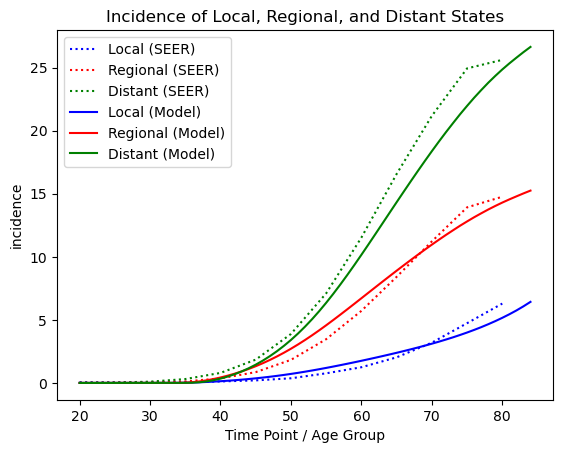

In [158]:
temp = tmat.copy()

# Healthy to local
temp[:30, 0, 1] *= 0.2
temp[30:, 0, 1] *= 1.2
temp[50:, 0, 1] *= 1.4

# Loc to Reg
temp[:, 1, 2] = 0.2
temp[50:, 1, 2] = np.linspace(0.2, 0.05, 15)

# Reg to Dis
temp[:, 2, 3] = 0.45
temp[25:35, 2, 3] = np.linspace(0.45, 0.55, 10)
temp[35:, 2, 3] = 0.55
temp[50:, 2, 3] = np.linspace(0.55, 0.5, 15)

# Detection
temp[:, 2, 5] = 0.3
temp[:, 3, 6] = 0.50

temp = temp[::5,:,:]
tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], temp, axis=0, smooth=0.001)(c.ages_1y)
tmat_smoothed = add_acm(tmat_smoothed)
tmat_smoothed = add_csd(tmat_smoothed)
tmat_smoothed = constrain_matrix(tmat_smoothed)
tmat_smoothed = row_normalize(tmat_smoothed)
p.plot_vs_seer(run_markov(tmat_smoothed)[0], c.seer_inc, show_plot=True)

In [159]:
np.save("../out/tmats/20241219_2250.npy", tmat_smoothed)

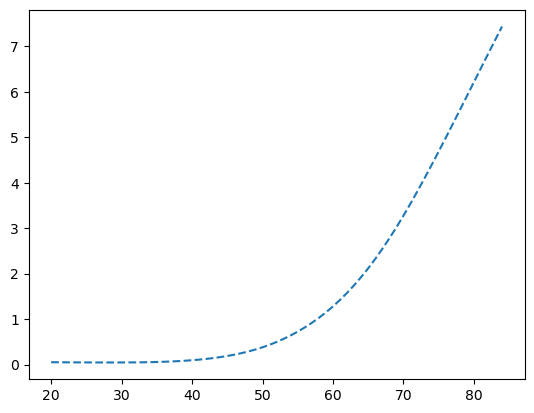

In [56]:
smooth=csaps(c.ages_5y, c.seer_inc_5y['LocalU'], smooth=0.01)(c.ages_1y)
plt.plot(c.ages_1y, smooth, linestyle="--")

In [17]:
tmat=np.load("../out/tmats/20241219_2250_tmat.npy")

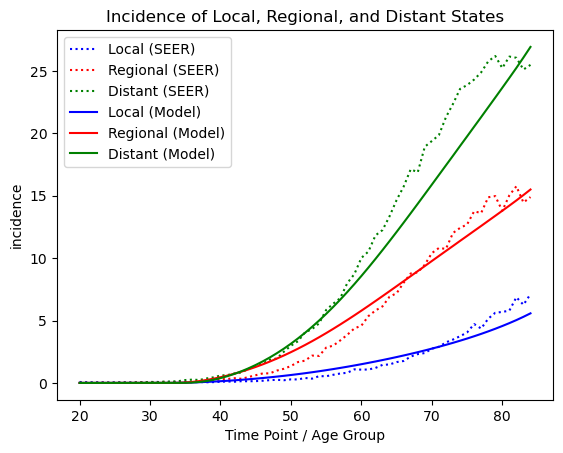

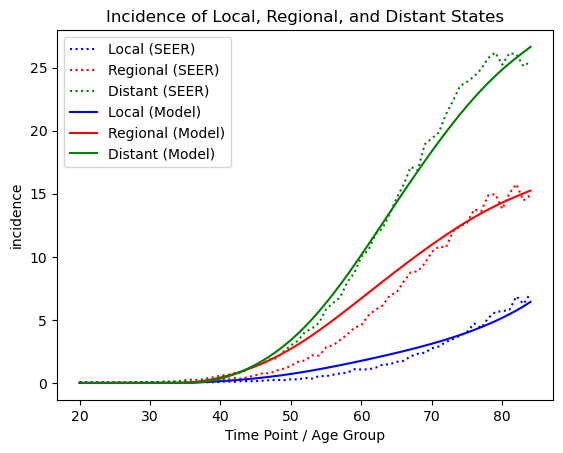

In [19]:
temp = tmat[::5,:,:].copy()
tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], temp, axis=0, smooth=0.001)(c.ages_1y)
tmat_smoothed = add_acm(tmat_smoothed)
tmat_smoothed = add_csd(tmat_smoothed)
tmat_smoothed = constrain_matrix(tmat_smoothed)
tmat_smoothed = row_normalize(tmat_smoothed)
p.plot_vs_seer(run_markov(tmat_smoothed)[0], c.seer_inc, show_plot=True)
p.plot_vs_seer(run_markov(tmat)[0], c.seer_inc, show_plot=True)

In [ ]:
np.save("../out/tmats/20241220_0723_tmat.npy", tmat_smoothed)

### Manhandling tmat double risk

In [8]:
tmat = np.load("../out/double/tmats/20241226_1938_tmat.npy")

In [24]:
p.extract_transition_probs(tmat, type="treeage", metric="avg", age_range=c.ages_1y)

,From State,To State,Age 30,Age 75,Min,Max,Avg
0,healthy,u_PDAC_loc,0.00139,0.00996,0.00000,0.01060,0.00607
1,u_PDAC_loc,u_PDAC_reg,0.00150,0.01009,0.00000,0.01104,0.00633
2,u_PDAC_reg,u_PDAC_dis,0.00518,0.02172,0.00000,0.03655,0.02027
3,u_PDAC_loc,d_PDAC_loc,0.00016,0.00023,0.00005,0.00043,0.00015
4,u_PDAC_reg,d_PDAC_reg,0.02732,0.00890,0.00735,0.03647,0.01626
5,u_PDAC_dis,d_PDAC_dis,0.12766,0.17680,0.12658,0.18998,0.15622


There is no reason that u_Reg to d_Reg should be less than 10%... I think I need to introduce some constraints. 

## Post-processing

In [28]:
def smooth_tmat(mat, save=False, outpath=c.OUTPUT_PATHS['tmats'], timestamp=""): # (sex: 2, race: 2, age_buckets: 10, state: 18, state: 18)
    
    # Anchor with mean at 100 and Smooth interpolation over age
    tmat_anchored = np.concatenate([mat, np.minimum(mat[-1:, :, :], np.mean(mat, axis=0, keepdims=True))], axis=0) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
    tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
    tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=0)(np.linspace(20,100,81)).clip(0.0, 1.0)

    # If smoothed tmat is exp increasing towards end, used anchored probs
    increasing_at_100 = tmat[-2:-1, :, :] < tmat[-1:, :, :]
    tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
    transition_mask = np.zeros((13, 13), dtype=bool)
    from_states, to_states= c.transitions_itos.keys()
    transition_mask[from_states, to_states] = True
    tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, ...], tmat_anchored, tmat)

    tmat = tmat_anchored
    tmat = row_normalize(tmat)

    if save:
      os.makedirs(outpath, exist_ok=True)
      name = f"tmat_{timestamp}"
      np.save(f"{outpath}/{name}.npy", tmat)
      
    return tmat

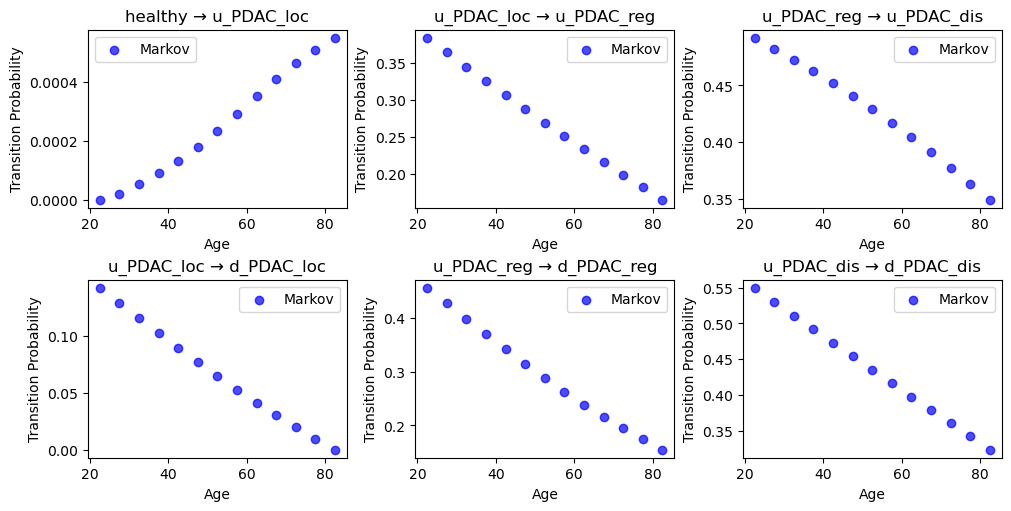

In [31]:
p.plot_params(result, show_plot=True)
markov_tmat = result
treeage_tmat = smooth_tmat(markov_tmat, save=False, timestamp="20241218_1605")
p.plot_params(markov_tmat, treeage_tmat, save_imgs=False, show_plot=True)

### Sojourn times (come back later)

In [8]:
tmat = np.load("../out/avg/tmats/20241220_0922_tmat.npy")
cp = gof.cancer_progression(tmat)
st = gof.sojourn_time(tmat)
print(cp)
print(st)

[ 9.242638983  9.144135678  9.048945383  8.957385353  8.869105969  8.783535464  8.700025200  8.618639626  8.538966578  8.461144263  8.385411792  8.311878992  8.240429363  8.171276166  8.104339088  8.039165376  7.975992482  7.915140784  7.856662344  7.800204778  7.745089195  7.691003524  7.637836677
  7.585572069  7.534315127  7.483885900  7.434284092  7.385505084  7.337328716  7.289244414  7.241702916  7.193991891  7.144917020  7.094489973  7.043770407  6.994253749  6.945881586  6.897412505  6.848076170  6.797774461  6.746434139  6.695278120  6.645320441  6.597111196  6.549582097  6.501442204
  6.449376386  6.395371526  6.338205659  6.278191419  6.216234165  6.149672338  6.085499349  5.999418085  5.923526163  5.832141131  5.743434043  5.637694661  5.533300249  5.420961133  5.304933966  5.181399963  5.039498691  4.892215559  4.747208732]
[ 3.577456701  3.538797869  3.501370334  3.465235886  3.430281440  3.396337049  3.363214378  3.330912254  3.299306101  3.268415833  3.238288205  3.2089

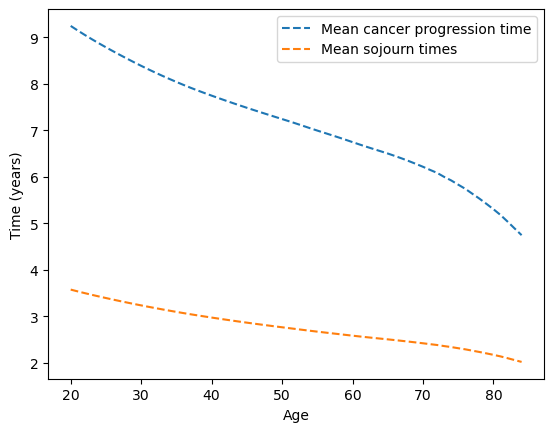

In [ ]:
plt.plot(c.ages_1y, cp, linestyle='--', label="Mean cancer progression times")
plt.plot(c.ages_1y, st, linestyle='--', label="Mean sojourn times")
plt.xlabel("Age")
plt.ylabel("Time (years)")
plt.legend()